<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/6.%201Q%20DD%20Dephasing%20Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [ ]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 28.2 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# CP CPMG UDD XY4 XY8 XY16 Sequence

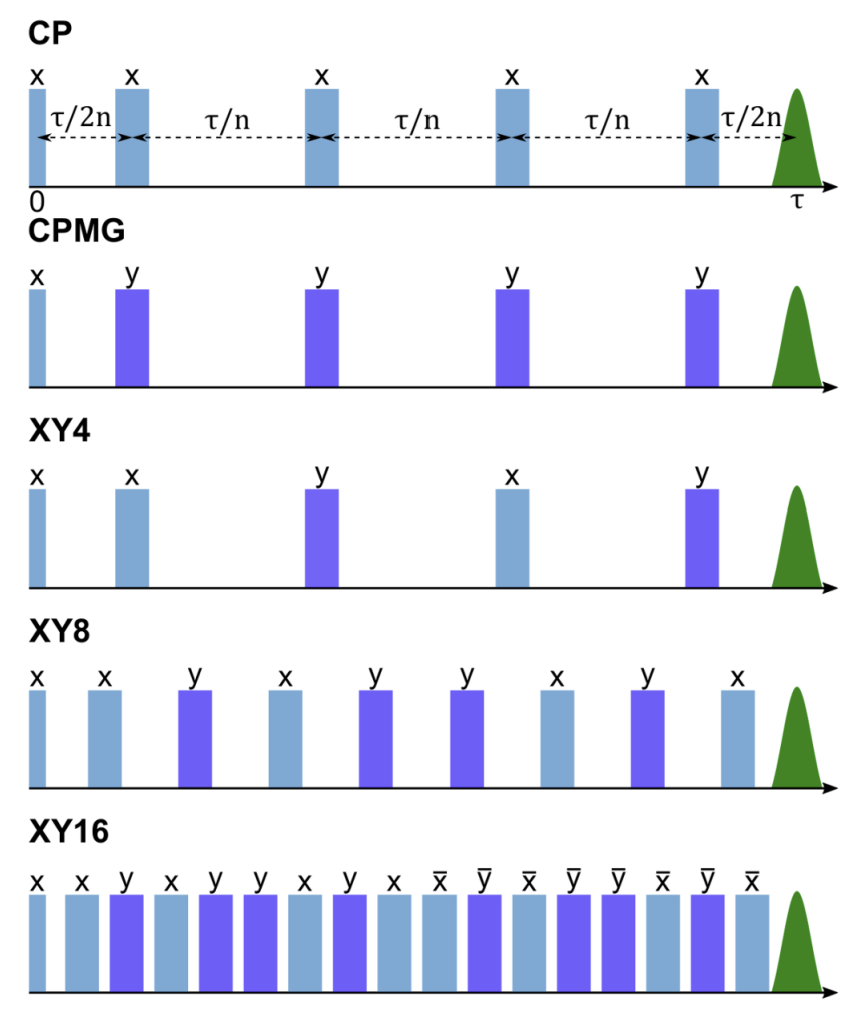

In [ ]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [ ]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [ ]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

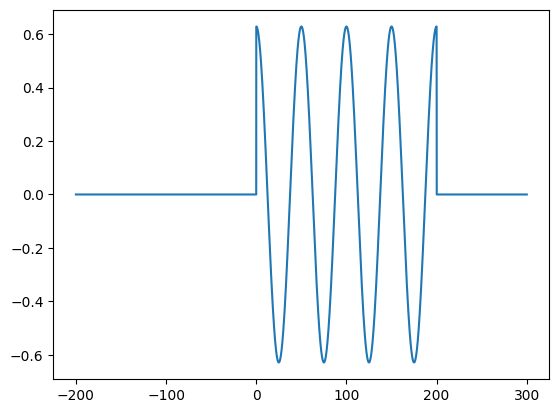

In [ ]:
# resonator drive pulse simulation

tlist = np.linspace(-200, 300, 10000)
plt.figure()
plt.plot(tlist, Hrd_lab_frame(tlist, {'A': 2*np.pi*0.1, 'T_srt_r': 0, 'T_end_r': 200, 'Omega_rd': 2*np.pi*0.02}))

## CP CPMG UDD Sequence

In [ ]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [ ]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [ ]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

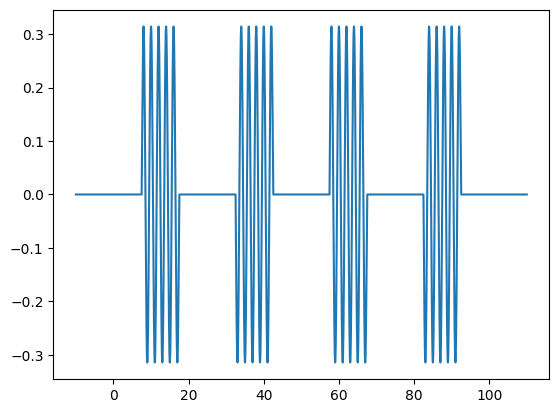

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

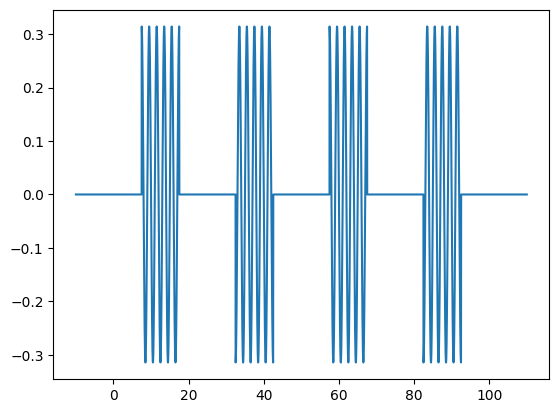

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

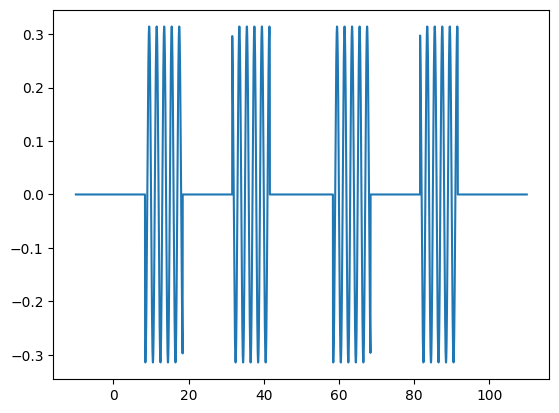

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 4, 'Omega_qd': 2*np.pi*0.5}))

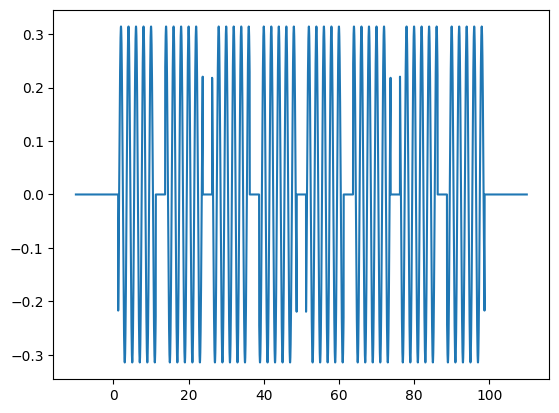

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CP_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

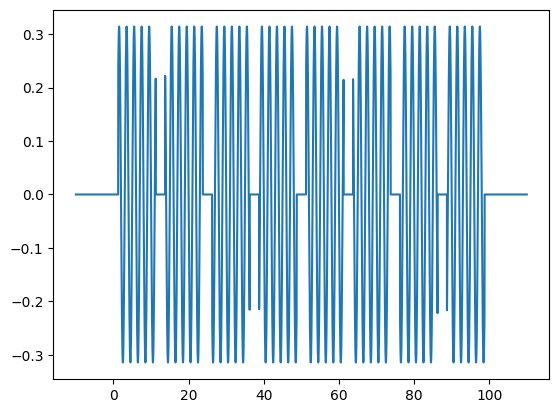

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, CPMG_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

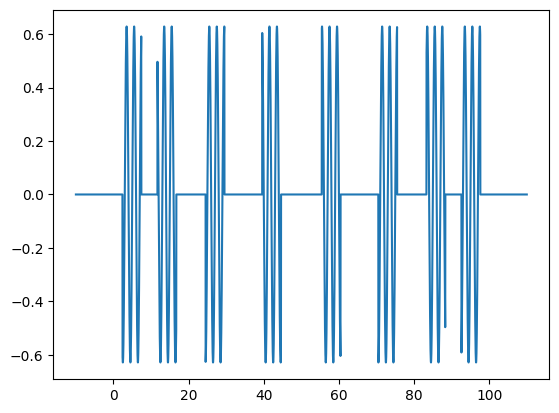

In [ ]:
# qubit drive pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'N_seq': 8, 'Omega_qd': 2*np.pi*0.5}))

## XY4 XY8 XY16 Sequence

In [ ]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [ ]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [ ]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

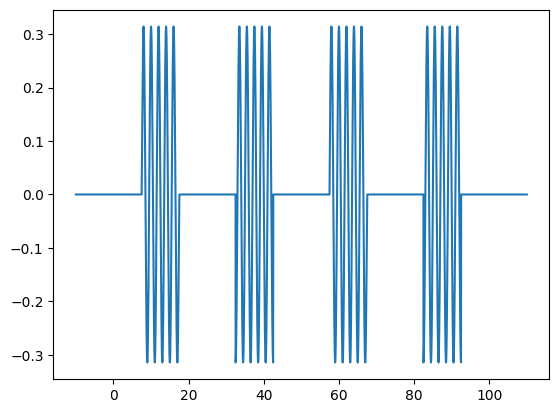

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

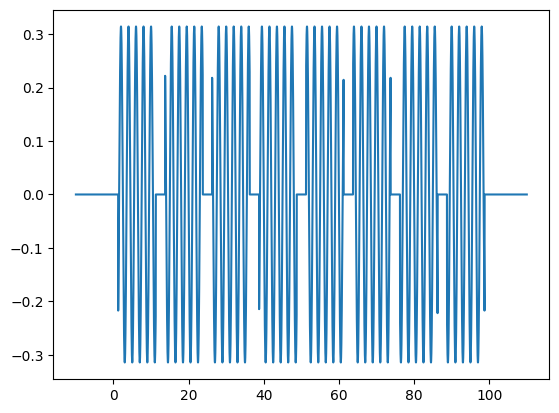

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY8_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

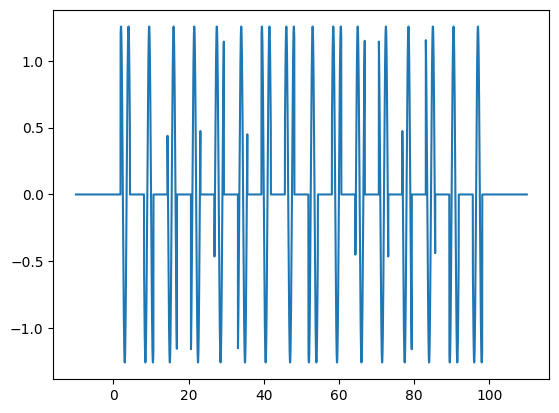

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, XY16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

## UDD4 UDD8 UDD16 Sequence

In [ ]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [ ]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [ ]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

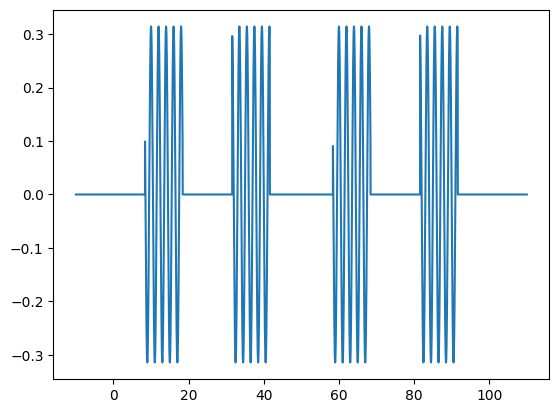

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD4_lab_frame(tlist, {'B': 2*np.pi*0.05, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

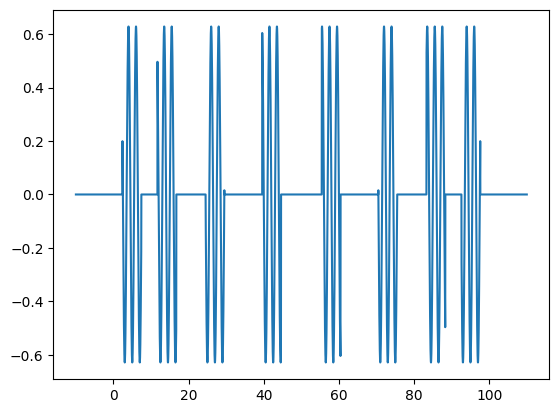

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD8_lab_frame(tlist, {'B': 2*np.pi*0.1, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

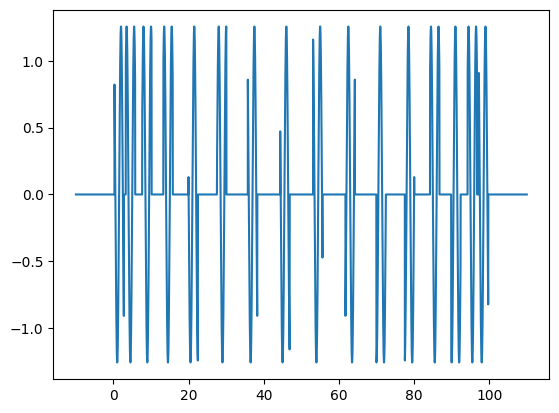

In [ ]:
# qubit pulse simulation
tlist = np.linspace(-10, 110, 10000)
plt.figure()
plt.plot(tlist, UDD16_lab_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt_q': 0, 'T_end_q': 100, 'Omega_qd': 2*np.pi*0.5}))

# Goal of this paper

Goal : Investigate the effect of dynamical decoupling in coherent photon case

Total evolution time : 300ns ~ 1000ns

Condition 1 : with Purcell Filter

Condition 2 : Readout Resonator photon number n = 0.02, 0.04, 0.06, 0.08, 0.10

In [ ]:
tau_list = np.array([100*(k+3) for k in range(8)])

In [ ]:
tot_coherence_list_2 = [np.array([0.92675435, 0.91012542, 0.89374428, 0.8776592 , 0.86186642,
        0.84636745, 0.831137  , 0.81617608]),
 np.array([0.9240832 , 0.91584469, 0.89398067, 0.88087367, 0.86313117,
        0.85014767, 0.83203706, 0.81973636]),
 np.array([0.92192838, 0.91227227, 0.89468949, 0.87797554, 0.86217688,
        0.84973625, 0.83580873, 0.8193481 ]),
 np.array([0.91736576, 0.89728202, 0.8882308 , 0.87442067, 0.86054057,
        0.8494847 , 0.83654597, 0.81768476])]

In [ ]:
tot_coherence_list_4 = [np.array([0.89323879, 0.86548864, 0.83859116, 0.81253067, 0.78728265,
        0.76283349, 0.73912705, 0.71615307]),
 np.array([0.89638284, 0.87641001, 0.84862445, 0.82602756, 0.79934396,
        0.77630959, 0.7541559 , 0.72719627]),
 np.array([0.89571454, 0.8796608 , 0.85427211, 0.82593515, 0.80548723,
        0.78496669, 0.76071477, 0.7368201 ]),
 np.array([0.87733674, 0.85165112, 0.84065224, 0.82437971, 0.80762144,
        0.79110992, 0.76931003, 0.74680836])]

In [ ]:
tot_coherence_list_6 = [np.array([0.80821766, 0.75481178, 0.70497374, 0.6584153 , 0.61493665,
        0.57434644, 0.53641227, 0.50098333]),
 np.array([0.83698421, 0.79749337, 0.7503814 , 0.70664103, 0.66002144,
        0.62194775, 0.58061076, 0.54441647]),
 np.array([0.83800904, 0.80932713, 0.76896506, 0.72079158, 0.67949329,
        0.64239205, 0.606859  , 0.56933596]),
 np.array([0.80070061, 0.7607999 , 0.74017102, 0.71919892, 0.69365007,
        0.66828689, 0.63470386, 0.60053358])]

In [ ]:
tot_coherence_list_8 = [np.array([0.71495663, 0.63886235, 0.57091374, 0.51017372, 0.45590605,
        0.40742631, 0.36407598, 0.32534347]),
 np.array([0.76694696, 0.70572342, 0.64448425, 0.58270097, 0.51752486,
        0.46682989, 0.42073016, 0.37607139]),
 np.array([0.77038195, 0.72630213, 0.66905147, 0.60369298, 0.55003917,
        0.50342763, 0.45328488, 0.4118175]),
 np.array([0.72413579, 0.6656815 , 0.63457026, 0.6069539 , 0.57286801,
        0.53918152, 0.49680188, 0.45496268])]

In [ ]:
tot_coherence_list_10 = [np.array([0.57449675, 0.4751737 , 0.3930615 , 0.3251178 , 0.26893325,
        0.22246789, 0.18400597, 0.15220575]),
 np.array([0.6592029 , 0.56407791, 0.48424694, 0.40080146, 0.33098167,
        0.27608294, 0.22718396, 0.19220842]),
 np.array([0.6617697 , 0.59749425, 0.5207705 , 0.44404531, 0.37588696,
        0.31743552, 0.27036727, 0.22719123]),
 np.array([0.61996531, 0.53310174, 0.48565895, 0.44876275, 0.40715156,
        0.364352  , 0.31792533, 0.2730928 ])]

Text(0, 0.5, 'Coherence')

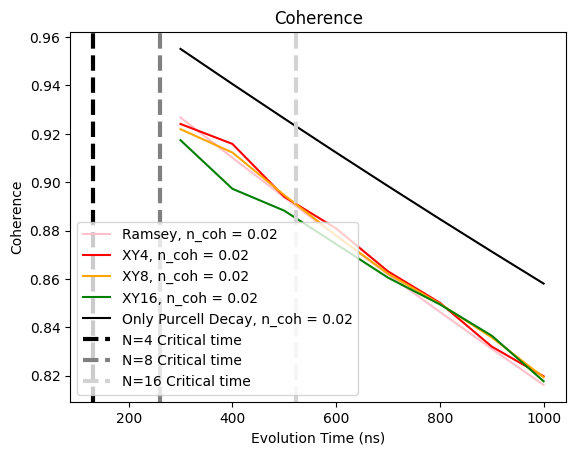

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_2[0], label = 'Ramsey, n_coh = 0.02', color='pink')
plt.plot(tau_list, tot_coherence_list_2[1], label = 'XY4, n_coh = 0.02', color='red')
plt.plot(tau_list, tot_coherence_list_2[2], label = 'XY8, n_coh = 0.02', color='orange')
plt.plot(tau_list, tot_coherence_list_2[3], label = 'XY16, n_coh = 0.02', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.02', color='black')

plt.axvline(4/0.03061, 0, 1, linestyle='--', label = 'N=4 Critical time', color='black', linewidth=3)
plt.axvline(8/0.03061, 0, 1, linestyle='--', label = 'N=8 Critical time', color='gray', linewidth=3)
plt.axvline(16/0.03061, 0, 1, linestyle='--', label = 'N=16 Critical time', color='lightgray', linewidth=3)

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

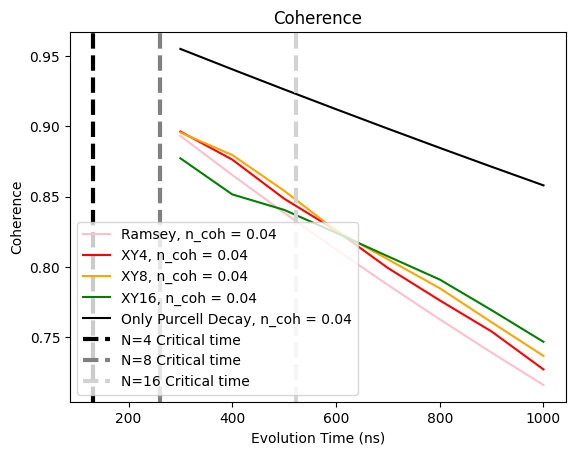

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_4[0], label = 'Ramsey, n_coh = 0.04', color='pink')
plt.plot(tau_list, tot_coherence_list_4[1], label = 'XY4, n_coh = 0.04', color='red')
plt.plot(tau_list, tot_coherence_list_4[2], label = 'XY8, n_coh = 0.04', color='orange')
plt.plot(tau_list, tot_coherence_list_4[3], label = 'XY16, n_coh = 0.04', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.04', color='black')

plt.axvline(4/0.03061, 0, 1, linestyle='--', label = 'N=4 Critical time', color='black', linewidth=3)
plt.axvline(8/0.03061, 0, 1, linestyle='--', label = 'N=8 Critical time', color='gray', linewidth=3)
plt.axvline(16/0.03061, 0, 1, linestyle='--', label = 'N=16 Critical time', color='lightgray', linewidth=3)

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

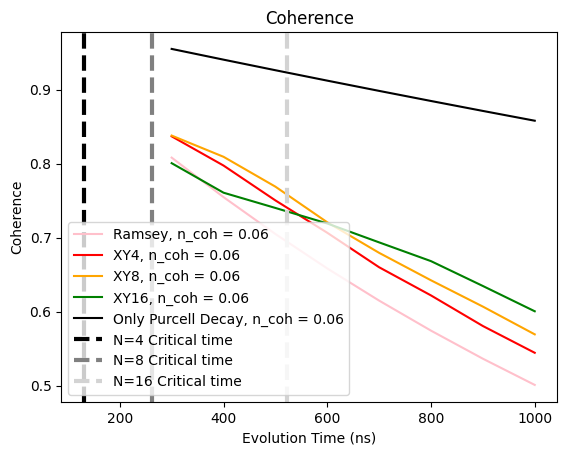

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_6[0], label = 'Ramsey, n_coh = 0.06', color='pink')
plt.plot(tau_list, tot_coherence_list_6[1], label = 'XY4, n_coh = 0.06', color='red')
plt.plot(tau_list, tot_coherence_list_6[2], label = 'XY8, n_coh = 0.06', color='orange')
plt.plot(tau_list, tot_coherence_list_6[3], label = 'XY16, n_coh = 0.06', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.06', color='black')

plt.axvline(4/0.03061, 0, 1, linestyle='--', label = 'N=4 Critical time', color='black', linewidth=3)
plt.axvline(8/0.03061, 0, 1, linestyle='--', label = 'N=8 Critical time', color='gray', linewidth=3)
plt.axvline(16/0.03061, 0, 1, linestyle='--', label = 'N=16 Critical time', color='lightgray', linewidth=3)

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

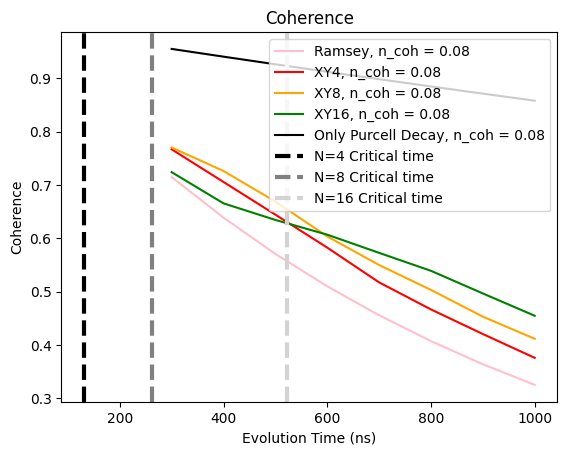

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_8[0], label = 'Ramsey, n_coh = 0.08', color='pink')
plt.plot(tau_list, tot_coherence_list_8[1], label = 'XY4, n_coh = 0.08', color='red')
plt.plot(tau_list, tot_coherence_list_8[2], label = 'XY8, n_coh = 0.08', color='orange')
plt.plot(tau_list, tot_coherence_list_8[3], label = 'XY16, n_coh = 0.08', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.08', color='black')

plt.axvline(4/0.03061, 0, 1, linestyle='--', label = 'N=4 Critical time', color='black', linewidth=3)
plt.axvline(8/0.03061, 0, 1, linestyle='--', label = 'N=8 Critical time', color='gray', linewidth=3)
plt.axvline(16/0.03061, 0, 1, linestyle='--', label = 'N=16 Critical time', color='lightgray', linewidth=3)

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Coherence')

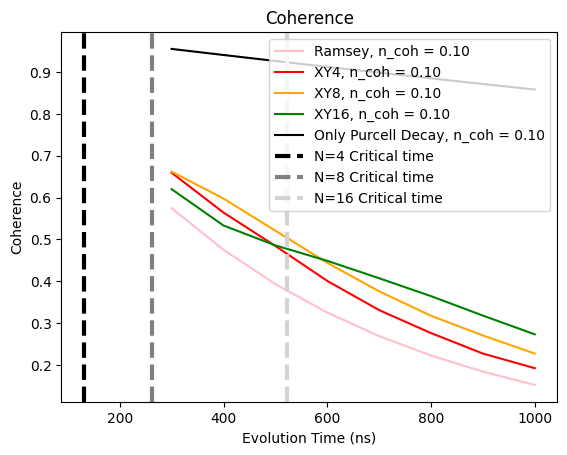

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_10[0], label = 'Ramsey, n_coh = 0.10', color='pink')
plt.plot(tau_list, tot_coherence_list_10[1], label = 'XY4, n_coh = 0.10', color='red')
plt.plot(tau_list, tot_coherence_list_10[2], label = 'XY8, n_coh = 0.10', color='orange')
plt.plot(tau_list, tot_coherence_list_10[3], label = 'XY16, n_coh = 0.10', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.10', color='black')

plt.axvline(4/0.03061, 0, 1, linestyle='--', label = 'N=4 Critical time', color='black', linewidth=3)
plt.axvline(8/0.03061, 0, 1, linestyle='--', label = 'N=8 Critical time', color='gray', linewidth=3)
plt.axvline(16/0.03061, 0, 1, linestyle='--', label = 'N=16 Critical time', color='lightgray', linewidth=3)

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

Text(0, 0.5, 'Pure Dephasing Rate (GHz)')

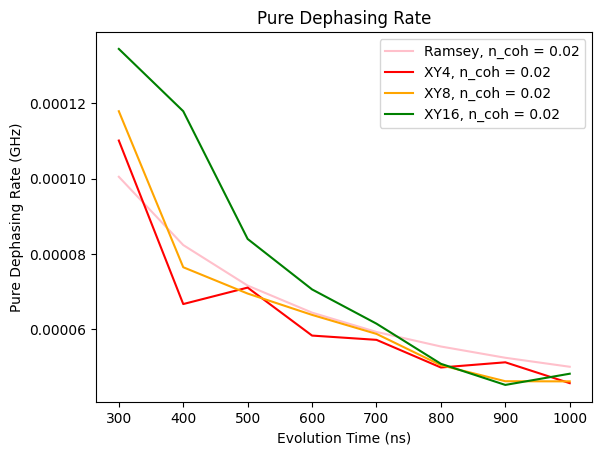

In [ ]:
# Plot Results

plt.plot(tau_list, -np.log(tot_coherence_list_2[0])/(tau_list) -0.000153055, label = 'Ramsey, n_coh = 0.02', color='pink')
plt.plot(tau_list, -np.log(tot_coherence_list_2[1])/(tau_list) -0.000153055, label = 'XY4, n_coh = 0.02', color='red')
plt.plot(tau_list, -np.log(tot_coherence_list_2[2])/(tau_list) -0.000153055, label = 'XY8, n_coh = 0.02', color='orange')
plt.plot(tau_list, -np.log(tot_coherence_list_2[3])/(tau_list) -0.000153055, label = 'XY16, n_coh = 0.02', color='green')

plt.legend()
plt.title('Pure Dephasing Rate')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Pure Dephasing Rate (GHz)')

Text(0, 0.5, 'Pure Dephasing Rate (GHz)')

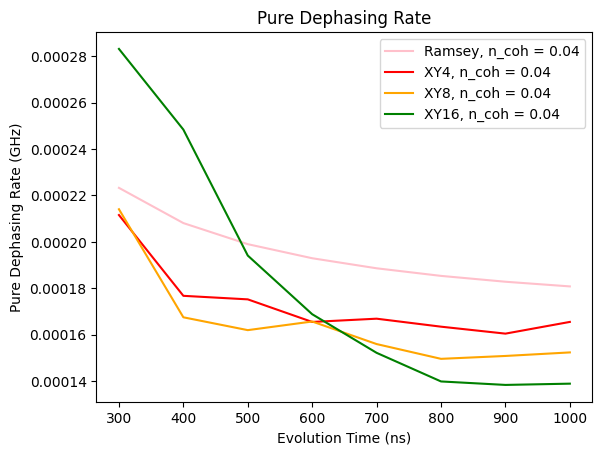

In [ ]:
# Plot Results

plt.plot(tau_list, -np.log(tot_coherence_list_4[0])/(tau_list) -0.000153055, label = 'Ramsey, n_coh = 0.04', color='pink')
plt.plot(tau_list, -np.log(tot_coherence_list_4[1])/(tau_list) -0.000153055, label = 'XY4, n_coh = 0.04', color='red')
plt.plot(tau_list, -np.log(tot_coherence_list_4[2])/(tau_list) -0.000153055, label = 'XY8, n_coh = 0.04', color='orange')
plt.plot(tau_list, -np.log(tot_coherence_list_4[3])/(tau_list) -0.000153055, label = 'XY16, n_coh = 0.04', color='green')

plt.legend()
plt.title('Pure Dephasing Rate')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Pure Dephasing Rate (GHz)')

Text(0, 0.5, 'Pure Dephasing Rate (GHz)')

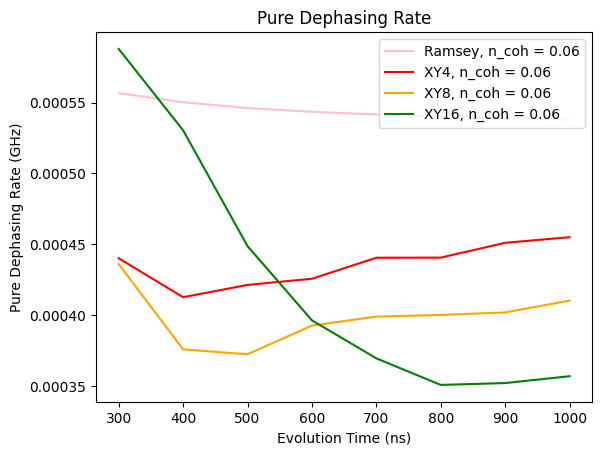

In [ ]:
# Plot Results

plt.plot(tau_list, -np.log(tot_coherence_list_6[0])/(tau_list) -0.000153055, label = 'Ramsey, n_coh = 0.06', color='pink')
plt.plot(tau_list, -np.log(tot_coherence_list_6[1])/(tau_list) -0.000153055, label = 'XY4, n_coh = 0.06', color='red')
plt.plot(tau_list, -np.log(tot_coherence_list_6[2])/(tau_list) -0.000153055, label = 'XY8, n_coh = 0.06', color='orange')
plt.plot(tau_list, -np.log(tot_coherence_list_6[3])/(tau_list) -0.000153055, label = 'XY16, n_coh = 0.06', color='green')

plt.legend()
plt.title('Pure Dephasing Rate')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Pure Dephasing Rate (GHz)')

Text(0, 0.5, 'Pure Dephasing Rate (GHz)')

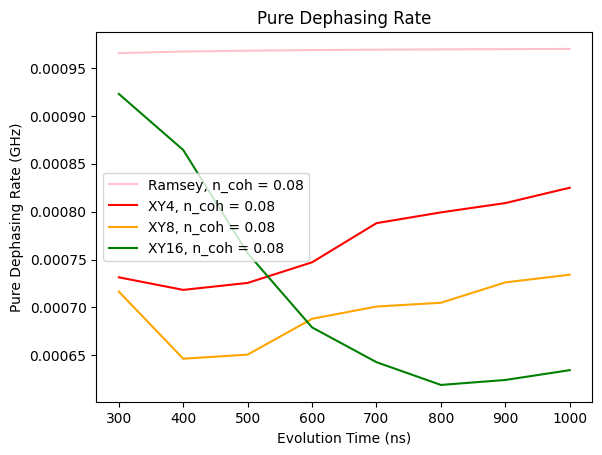

In [ ]:
# Plot Results

plt.plot(tau_list, -np.log(tot_coherence_list_8[0])/(tau_list) -0.000153055, label = 'Ramsey, n_coh = 0.08', color='pink')
plt.plot(tau_list, -np.log(tot_coherence_list_8[1])/(tau_list) -0.000153055, label = 'XY4, n_coh = 0.08', color='red')
plt.plot(tau_list, -np.log(tot_coherence_list_8[2])/(tau_list) -0.000153055, label = 'XY8, n_coh = 0.08', color='orange')
plt.plot(tau_list, -np.log(tot_coherence_list_8[3])/(tau_list) -0.000153055, label = 'XY16, n_coh = 0.08', color='green')

plt.legend()
plt.title('Pure Dephasing Rate')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Pure Dephasing Rate (GHz)')

Text(0, 0.5, 'Pure Dephasing Rate (GHz)')

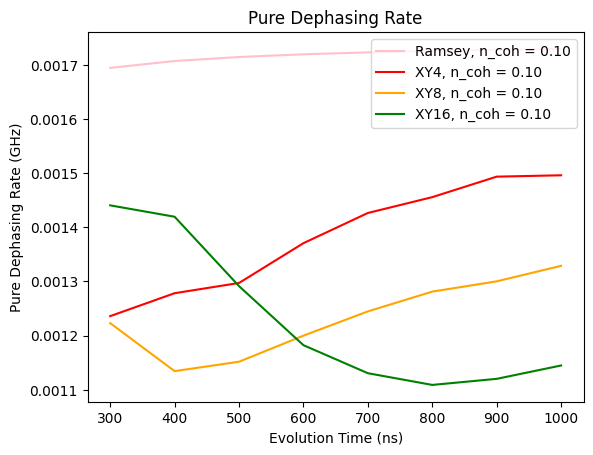

In [ ]:
# Plot Results

plt.plot(tau_list, -np.log(tot_coherence_list_10[0])/(tau_list) -0.000153055, label = 'Ramsey, n_coh = 0.10', color='pink')
plt.plot(tau_list, -np.log(tot_coherence_list_10[1])/(tau_list) -0.000153055, label = 'XY4, n_coh = 0.10', color='red')
plt.plot(tau_list, -np.log(tot_coherence_list_10[2])/(tau_list) -0.000153055, label = 'XY8, n_coh = 0.10', color='orange')
plt.plot(tau_list, -np.log(tot_coherence_list_10[3])/(tau_list) -0.000153055, label = 'XY16, n_coh = 0.10', color='green')

plt.legend()
plt.title('Pure Dephasing Rate')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Pure Dephasing Rate (GHz)')

# Dynamical Decoupling Simulation (Coherent Photon Case)

With Purcell Filter

## Readout Resonator Amplitude $ A = 0.05GHz $

Readout Resonator Photon number $ n = 0.02 $

In [ ]:
# constant
N = 2

A = 0.05 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite

tot_coherence_list_2 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [ ]:
# Ramsey

N_seq = 0
coherence_list_Ramsey = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_Ramsey.append(avg)


coherence_list_Ramsey = np.array(coherence_list_Ramsey)
tot_coherence_list_2.append(coherence_list_Ramsey)

0
1
2
3
4
5
6
7


In [ ]:
# XY4

coherence_list_XY4 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY4.append(avg)


coherence_list_XY4 = np.array(coherence_list_XY4)
tot_coherence_list_2.append(coherence_list_XY4)

0
1
2
3
4
5
6
7


In [ ]:
# XY8

coherence_list_XY8 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY8.append(avg)


coherence_list_XY8 = np.array(coherence_list_XY8)
tot_coherence_list_2.append(coherence_list_XY8)

0
1
2
3
4
5
6
7


In [ ]:
# XY16

coherence_list_XY16 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY16.append(avg)


coherence_list_XY16 = np.array(coherence_list_XY16)
tot_coherence_list_2.append(coherence_list_XY16)

0
1
2
3
4
5
6
7


In [ ]:
tot_coherence_list_2

[array([0.92675435, 0.91012542, 0.89374428, 0.8776592 , 0.86186642,
        0.84636745, 0.831137  , 0.81617608]),
 array([0.9240832 , 0.91584469, 0.89398067, 0.88087367, 0.86313117,
        0.85014767, 0.83203706, 0.81973636]),
 array([0.92192838, 0.91227227, 0.89468949, 0.87797554, 0.86217688,
        0.84973625, 0.83580873, 0.8193481 ]),
 array([0.91736576, 0.89728202, 0.8882308 , 0.87442067, 0.86054057,
        0.8494847 , 0.83654597, 0.81768476])]

In [ ]:
tot_coherence_list_2 = [np.array([0.92675435, 0.91012542, 0.89374428, 0.8776592 , 0.86186642,
        0.84636745, 0.831137  , 0.81617608]),
 np.array([0.9240832 , 0.91584469, 0.89398067, 0.88087367, 0.86313117,
        0.85014767, 0.83203706, 0.81973636]),
 np.array([0.92192838, 0.91227227, 0.89468949, 0.87797554, 0.86217688,
        0.84973625, 0.83580873, 0.8193481 ]),
 np.array([0.91736576, 0.89728202, 0.8882308 , 0.87442067, 0.86054057,
        0.8494847 , 0.83654597, 0.81768476])]

Text(0, 0.5, 'Coherence')

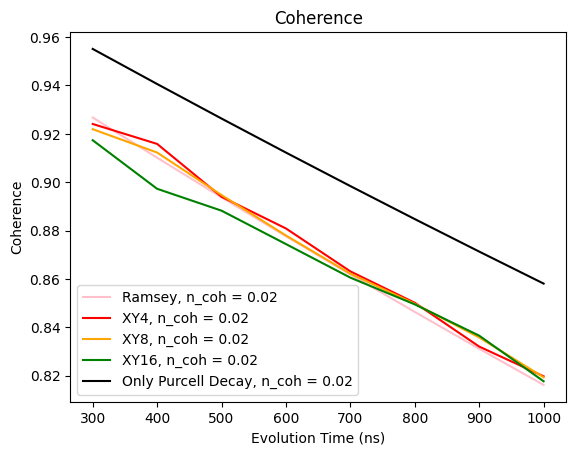

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_2[0], label = 'Ramsey, n_coh = 0.02', color='pink')
plt.plot(tau_list, tot_coherence_list_2[1], label = 'XY4, n_coh = 0.02', color='red')
plt.plot(tau_list, tot_coherence_list_2[2], label = 'XY8, n_coh = 0.02', color='orange')
plt.plot(tau_list, tot_coherence_list_2[3], label = 'XY16, n_coh = 0.02', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.02', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Readout Resonator Amplitude $ A = 0.06GHz $

Readout Resonator Photon number $ n = 0.04 $

In [ ]:
# constant
N = 2

A = 0.06 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite

tot_coherence_list_4 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [ ]:
# Ramsey

N_seq = 0
coherence_list_Ramsey = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_Ramsey.append(avg)


coherence_list_Ramsey = np.array(coherence_list_Ramsey)
tot_coherence_list_4.append(coherence_list_Ramsey)

0
1
2
3
4
5
6


KeyboardInterrupt: 

In [ ]:
# XY4

coherence_list_XY4 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY4.append(avg)


coherence_list_XY4 = np.array(coherence_list_XY4)
tot_coherence_list_4.append(coherence_list_XY4)

In [ ]:
# XY8

coherence_list_XY8 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY8.append(avg)


coherence_list_XY8 = np.array(coherence_list_XY8)
tot_coherence_list_4.append(coherence_list_XY8)

In [ ]:
# XY16

coherence_list_XY16 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(8):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY16.append(avg)


coherence_list_XY16 = np.array(coherence_list_XY16)
tot_coherence_list_4.append(coherence_list_XY16)

In [ ]:
tot_coherence_list_4

In [ ]:
tot_coherence_list_4 = [np.array([0.89323879, 0.86548864, 0.83859116, 0.81253067, 0.78728265,
        0.76283349, 0.73912705, 0.71615307]),
 np.array([0.89638284, 0.87641001, 0.84862445, 0.82602756, 0.79934396,
        0.77630959, 0.7541559 , 0.72719627]),
 np.array([0.89571454, 0.8796608 , 0.85427211, 0.82593515, 0.80548723,
        0.78496669, 0.76071477, 0.7368201 ]),
 np.array([0.87733674, 0.85165112, 0.84065224, 0.82437971, 0.80762144,
        0.79110992, 0.76931003, 0.74680836])]

Text(0, 0.5, 'Coherence')

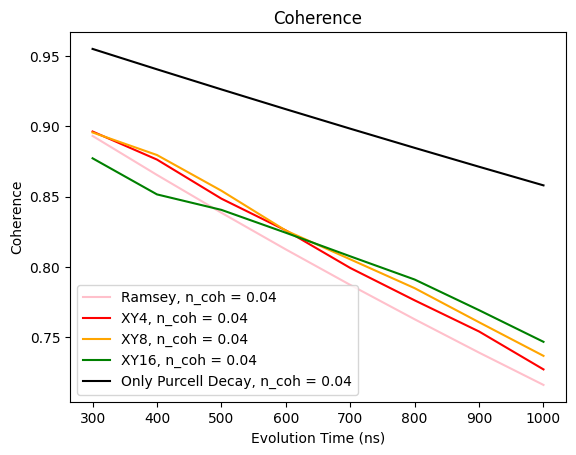

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_4[0], label = 'Ramsey, n_coh = 0.04', color='pink')
plt.plot(tau_list, tot_coherence_list_4[1], label = 'XY4, n_coh = 0.04', color='red')
plt.plot(tau_list, tot_coherence_list_4[2], label = 'XY8, n_coh = 0.04', color='orange')
plt.plot(tau_list, tot_coherence_list_4[3], label = 'XY16, n_coh = 0.04', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.04', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Readout Resonator Amplitude $ A = 0.07GHz $

Readout Resonator Photon number $ n = 0.06 $

In [ ]:
# constant
N = 2

A = 0.07 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite

tot_coherence_list_6 = []
tau_list = np.array([100*(k+3) for k in range(8)])

In [ ]:
# Ramsey

N_seq = 0
coherence_list_Ramsey = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_Ramsey.append(avg)


coherence_list_Ramsey = np.array(coherence_list_Ramsey)
tot_coherence_list_6.append(coherence_list_Ramsey)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
# XY4

coherence_list_XY4 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY4.append(avg)


coherence_list_XY4 = np.array(coherence_list_XY4)
tot_coherence_list_6.append(coherence_list_XY4)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
# XY8

coherence_list_XY8 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY8.append(avg)


coherence_list_XY8 = np.array(coherence_list_XY8)
tot_coherence_list_6.append(coherence_list_XY8)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [ ]:
# XY16

coherence_list_XY16 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY16.append(avg)


coherence_list_XY16 = np.array(coherence_list_XY16)
tot_coherence_list_6.append(coherence_list_XY16)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [ ]:
tot_coherence_list_6

[array([0.80821766, 0.75481178, 0.70497374, 0.6584153 , 0.61493665,
        0.57434644, 0.53641227, 0.50098333, 0.46792128, 0.43701913,
        0.4081463 , 0.38121402, 0.35604533, 0.33251392, 0.310571  ,
        0.29007652, 0.27089902, 0.25301624]),
 array([0.83698421, 0.79749337, 0.7503814 , 0.70664103, 0.66002144,
        0.62194775, 0.58061076, 0.54441647, 0.51867439, 0.47600719,
        0.45051207, 0.4210023 , 0.39101159, 0.37073917, 0.35283419,
        0.3314478 , 0.30867753, 0.28548566]),
 array([0.83800904, 0.80932713, 0.76896506, 0.72079158, 0.67949329,
        0.64239205, 0.606859  , 0.56933596, 0.53245527, 0.50688382,
        0.46986351, 0.44250844, 0.41440417, 0.38935524, 0.36372724,
        0.35436809, 0.32054622, 0.30248837]),
 array([0.80070061, 0.7607999 , 0.74017102, 0.71919892, 0.69365007,
        0.66828689, 0.63470386, 0.60053358, 0.56988513, 0.53106645,
        0.49969236, 0.47352773, 0.44661754, 0.42252527, 0.3946686 ,
        0.3749165 ])]

In [ ]:
tot_coherence_list_6 = [np.array([0.80821766, 0.75481178, 0.70497374, 0.6584153 , 0.61493665,
        0.57434644, 0.53641227, 0.50098333]),
 np.array([0.83698421, 0.79749337, 0.7503814 , 0.70664103, 0.66002144,
        0.62194775, 0.58061076, 0.54441647]),
 np.array([0.83800904, 0.80932713, 0.76896506, 0.72079158, 0.67949329,
        0.64239205, 0.606859  , 0.56933596]),
 np.array([0.80070061, 0.7607999 , 0.74017102, 0.71919892, 0.69365007,
        0.66828689, 0.63470386, 0.60053358])]

Text(0, 0.5, 'Coherence')

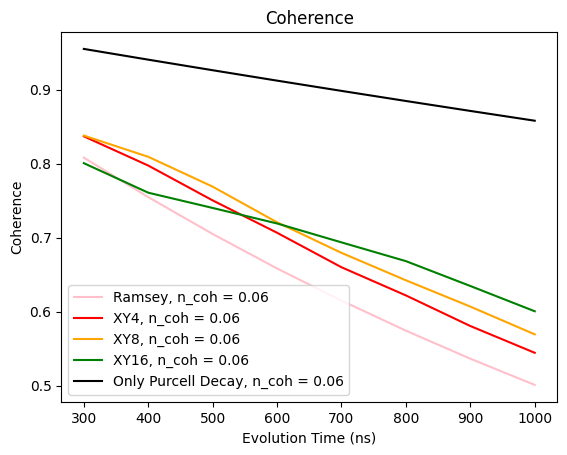

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_6[0], label = 'Ramsey, n_coh = 0.06', color='pink')
plt.plot(tau_list, tot_coherence_list_6[1], label = 'XY4, n_coh = 0.06', color='red')
plt.plot(tau_list, tot_coherence_list_6[2], label = 'XY8, n_coh = 0.06', color='orange')
plt.plot(tau_list, tot_coherence_list_6[3], label = 'XY16, n_coh = 0.06', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.06', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Readout Resonator Amplitude $ A = 0.077GHz $

Readout Resonator Photon number $ n = 0.08 $

In [ ]:
# constant
N = 2

A = 0.077 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite

tot_coherence_list_8 = []
tau_list = np.array([100*(k+3) for k in range(18)])

In [ ]:
# Ramsey

N_seq = 0
coherence_list_Ramsey = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_Ramsey.append(avg)


coherence_list_Ramsey = np.array(coherence_list_Ramsey)
tot_coherence_list_8.append(coherence_list_Ramsey)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
# XY4

coherence_list_XY4 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY4.append(avg)


coherence_list_XY4 = np.array(coherence_list_XY4)
tot_coherence_list_8.append(coherence_list_XY4)

In [ ]:
# XY8

coherence_list_XY8 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY8.append(avg)


coherence_list_XY8 = np.array(coherence_list_XY8)
tot_coherence_list_8.append(coherence_list_XY8)

In [ ]:
# XY16

coherence_list_XY16 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY16.append(avg)


coherence_list_XY16 = np.array(coherence_list_XY16)
tot_coherence_list_8.append(coherence_list_XY16)

In [ ]:
tot_coherence_list_8

In [ ]:
tot_coherence_list_8 = [np.array([0.71495663, 0.63886235, 0.57091374, 0.51017372, 0.45590605,
        0.40742631, 0.36407598, 0.32534347]),
 np.array([0.76694696, 0.70572342, 0.64448425, 0.58270097, 0.51752486,
        0.46682989, 0.42073016, 0.37607139]),
 np.array([0.77038195, 0.72630213, 0.66905147, 0.60369298, 0.55003917,
        0.50342763, 0.45328488, 0.4118175]),
 np.array([0.72413579, 0.6656815 , 0.63457026, 0.6069539 , 0.57286801,
        0.53918152, 0.49680188, 0.45496268])]

Text(0, 0.5, 'Coherence')

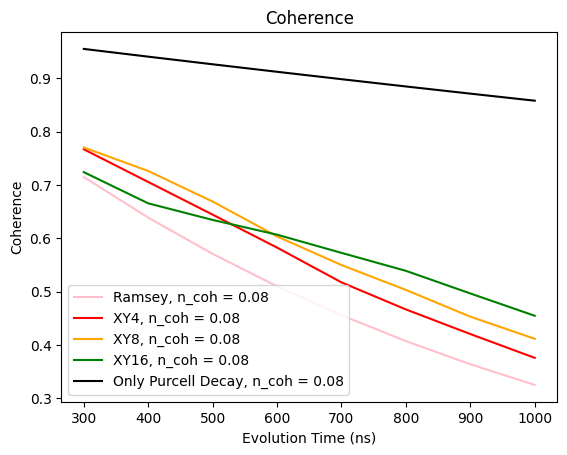

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_8[0], label = 'Ramsey, n_coh = 0.08', color='pink')
plt.plot(tau_list, tot_coherence_list_8[1], label = 'XY4, n_coh = 0.08', color='red')
plt.plot(tau_list, tot_coherence_list_8[2], label = 'XY8, n_coh = 0.08', color='orange')
plt.plot(tau_list, tot_coherence_list_8[3], label = 'XY16, n_coh = 0.08', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.08', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')

## Readout Resonator Amplitude $ A = 0.085GHz $

Readout Resonator Photon number $ n = 0.10 $

In [ ]:
# constant
N = 2

A = 0.085 * 2 * np.pi
B = 0.1 * 2 * np.pi

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.5         # qubit-resonator coupling in units of GHz
kappa_f = 2 * np.pi * 0.01  # external coupling rate of resonator in units of GHz

detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi    # qubit frequency in units of GHz

# operator
sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_composite = tensor(sx, qeye(N), qeye(N))
sy_composite = tensor(sy, qeye(N), qeye(N))
sz_composite = tensor(sz, qeye(N), qeye(N))
sp_composite = tensor(sp, qeye(N), qeye(N))
sm_composite = tensor(sm, qeye(N), qeye(N))

annihilate_composite_r = tensor(qeye(2), a, qeye(N))
create_composite_r = tensor(qeye(2), a.dag(), qeye(N))
number_composite_r = tensor(qeye(2), a.dag()*a, qeye(N))

annihilate_composite_f = tensor(qeye(2), qeye(N), b)
create_composite_f = tensor(qeye(2), qeye(N), b.dag())
number_composite_f = tensor(qeye(2), qeye(N), b.dag()*b)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite_r, number_composite_f]

psi_20 = tensor(basis(2,0), basis(N,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_composite + omega_r*number_composite_r + omega_f*number_composite_f + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_composite

tot_coherence_list_10 = []
tau_list = np.array([100*(k+3) for k in range(18)])

In [ ]:
# Ramsey

N_seq = 0
coherence_list_Ramsey = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_Ramsey.append(avg)


coherence_list_Ramsey = np.array(coherence_list_Ramsey)
tot_coherence_list_10.append(coherence_list_Ramsey)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [ ]:
# XY4

coherence_list_XY4 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY4_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY4.append(avg)


coherence_list_XY4 = np.array(coherence_list_XY4)
tot_coherence_list_10.append(coherence_list_XY4)

In [ ]:
# XY8

coherence_list_XY8 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY8_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY8.append(avg)


coherence_list_XY8 = np.array(coherence_list_XY8)
tot_coherence_list_10.append(coherence_list_XY8)

In [ ]:
# XY16

coherence_list_XY16 = []

# iterate for evolution time 300ns ~ 2000ns
for k in range(18):

  # Simulation
  tlist = np.linspace(0, 100*(k+3), 2000*(k+3))

  result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, XY16_lab_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 100*(k+3), 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
  )

  print(k)

  avg = 0
  for i in range(20):
    avg = avg + 2*np.abs(result.expect[3][-1-i])
  avg = avg/20

  coherence_list_XY16.append(avg)


coherence_list_XY16 = np.array(coherence_list_XY16)
tot_coherence_list_10.append(coherence_list_XY16)

In [ ]:
tot_coherence_list_10

In [ ]:
tot_coherence_list_10 = [np.array([0.57449675, 0.4751737 , 0.3930615 , 0.3251178 , 0.26893325,
        0.22246789, 0.18400597, 0.15220575]),
 np.array([0.6592029 , 0.56407791, 0.48424694, 0.40080146, 0.33098167,
        0.27608294, 0.22718396, 0.19220842]),
 np.array([0.6617697 , 0.59749425, 0.5207705 , 0.44404531, 0.37588696,
        0.31743552, 0.27036727, 0.22719123]),
 np.array([0.61996531, 0.53310174, 0.48565895, 0.44876275, 0.40715156,
        0.364352  , 0.31792533, 0.2730928 ])]

Text(0, 0.5, 'Coherence')

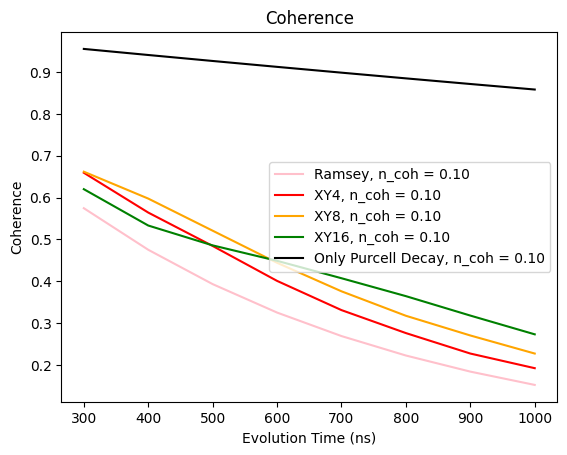

In [ ]:
# Plot Results

plt.plot(tau_list, tot_coherence_list_10[0], label = 'Ramsey, n_coh = 0.10', color='pink')
plt.plot(tau_list, tot_coherence_list_10[1], label = 'XY4, n_coh = 0.10', color='red')
plt.plot(tau_list, tot_coherence_list_10[2], label = 'XY8, n_coh = 0.10', color='orange')
plt.plot(tau_list, tot_coherence_list_10[3], label = 'XY16, n_coh = 0.10', color='green')
plt.plot(tau_list, np.exp(-0.000153055*tau_list), label = 'Only Purcell Decay, n_coh = 0.10', color='black')

plt.legend()
plt.title('Coherence')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Coherence')